# Project 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import scipy.sparse as sp
import scipy.sparse.linalg as sppla
import warnings
warnings.filterwarnings('ignore')

In [2]:
def main(sizenx, sizeny):
    sizex = 5
    sizey = 4
    x1d = np.linspace(0, sizex, sizenx)
    y1d = np.linspace(0, sizey, sizeny)
    x = np.zeros((len(x1d), len(y1d)))
    x[:] = x1d.reshape(-1, 1)
    y = np.zeros((len(x1d), len(y1d)))
    y[:] = y1d
    wthick = 0.3
    in_domain = (
    (
        (x > wthick) & (x < sizex-wthick)
        & (y > wthick) & (y < sizey-wthick)
    )
    &
    ~(
        (y > 2)
        &
        (y < 2.2)
        &
        (x < 5)
        & (x > 2)
    ))
    window = (
    (
        (y > 1.9) & (y < 3.4)
        & (x > 0) & (x < 0.3)
    )
    &
    ~(
        (x > (sizex))
        &
        (x < 4)
        &
        (y < sizey)
    ))
    heater = ((
        (y > 0.3) & (y < 0.55)
        & (x > 1.2) & (x < 2.7))
    &
    ~(
        (x > 5*(sizex))
        &
        (x < (4))
        &
        (y < sizey)))
    
    dof_num = np.cumsum(in_domain.astype(np.int32)).reshape(x.shape) - 1
    ndofs = np.max(dof_num) + 1
    xlen, ylen = x.shape
    xind = np.arange(xlen).reshape(-1, 1)
    yind = np.arange(ylen).reshape(1, -1)

    xind = xind + 0*yind
    yind = yind + 0*xind

    dofnr_to_geom_ind = np.zeros((ndofs, 2))

    dofnr_to_geom_ind[:, 0] = xind[in_domain]
    dofnr_to_geom_ind[:, 1] = yind[in_domain]
    
    def plotfunc(u):
        plt.imshow(u, extent=[x1d[0], x1d[-1], y1d[0], y1d[-1]])
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.gca().set_aspect("equal")
        
    room = in_domain.astype(np.int32) + 3*window.astype(np.int32) + heater.astype(np.int32)
    print("Room geometry")
    plt.figure()
    plotfunc(room)
    plt.show()
    
    #laplacian matrix
    def laplacian(sizenx, sizeny):
        row = []
        col = []
        data = []
        x1d = np.linspace(0, sizex, sizenx)
        y1d = np.linspace(0, sizey, sizeny)
        hx = x1d[1]-x1d[0]
        hy = y1d[1]-y1d[0]
        for idof in range(ndofs):
            dg = dofnr_to_geom_ind[idof]
            x,y = dg[0], dg[1]
            for dix, diy, h in [
                (1, 0, hx),
                (-1, 0, hx),
                (0, 1, hy),
                (0, -1, hy)]:
                nxx = int(x + dix)
                nyy = int(y + diy)
                if in_domain[nxx, nyy]:
                    ndof = dof_num[nxx, nyy]
                    row += [idof, idof]
                    col += [ndof, idof]
                    data += [1/(h**2), -1/(h**2)]
                elif window[nxx, nyy]:
                    row += [idof]
                    col += [idof]
                    data += [-1/(h**2)]
                else:
                    nx2, ny2 = x - dix, y - diy
                    ndf1 = dof_num[int(nx2), int(ny2)]
                    row += [idof, idof]
                    col += [idof, ndf1]
                    data += [1/(3*(h**2)), -1/(3*(h**2))]
        row = np.array(row)
        col = np.array(col)
        data = np.array(data)
        A = sp.coo_matrix((data, (row, col)), shape = (ndofs, ndofs))
        C = A.tocsr()
        return C
    
    #defining r = heater 
    flatdof = dof_num[in_domain]
    rflat = dof_num[heater]
    r = np.zeros_like(flatdof)
    r[rflat] = 100
    u0 = np.zeros(ndofs)
    
    laplacian = laplacian(sizenx, sizeny)
    
    #second order explicit runge-kutta method
    def runge_kutta(u):
        T = 30*np.maximum(sizex, sizey)
        hx = sizex/sizenx
        hy = sizey/sizeny
        ht = 0.5*0.9*(1/(1/(hx**2)+1/(hy**2)))
        nt = int(T/ht)+1
        t = np.arange(0, T, ht) 
        for i in range(30000):
            k1 = laplacian@u + r
            k2 = ht*(laplacian @ (u + ht*k1/2) + r)
            u = u + k2
        return u
    
    o = runge_kutta(u0)
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = o
    print("Runge-Kutta 2nd order")
    plt.figure()
    plotfunc(u_unflat)
    plt.show()
    
    #second order implicit midpoint
    def midpoint(u):
        T = 30*np.maximum(sizex, sizey)
        nt = 30000
        hx = sizex/sizenx
        hy = sizey/sizeny
        ht = 0.5*4*0.9*(1/(1/(hx**2)+1/(hy**2)))
        t = np.arange(0, T, ht)
        A = sp.identity(ndofs)-0.5*ht*laplacian
        solve = sppla.factorized(A)
        for i in range(nt):
            u = solve( u + 0.5*ht*laplacian@u + ht*r)
        return u
    
    m = midpoint(u0)
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = m
    print("Implicit Midpoint")
    plt.figure()
    plotfunc(u_unflat)
    plt.show()
    
    #steady-state 
    ss = sppla.spsolve(laplacian, -r)
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = ss
    print("Steady-State")
    plt.figure()
    plotfunc(u_unflat)
    plt.show()
    
    ur = np.random.rand(ndofs)
    
    #jacobi method
    def jacobi(u, N):
        D = sp.diags(laplacian.diagonal(), 0, format = 'coo')
        for i in range(N):
            u = sppla.spsolve(D, -r-(laplacian-D)@u)
        return u
    j = jacobi(ur, 300)
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = j
    print("Jacobi")
    plt.figure()
    plotfunc(u_unflat)
    plt.show()
    
    #damped jacobi 
    def damped(u, N):
        alpha = 0.005
        u = alpha*u + (1-alpha)*j
        return u
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = damped(ur, 300)
    print("Damped Jacobi")
    plt.figure()
    plotfunc(u_unflat)
    plt.show()

Room geometry


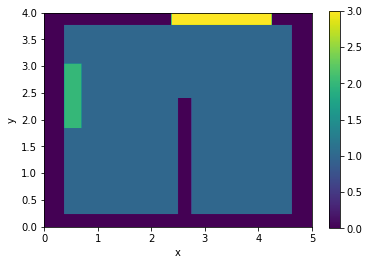

Runge-Kutta 2nd order


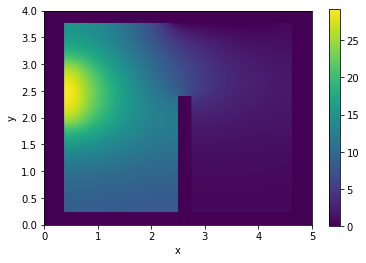

Implicit Midpoint


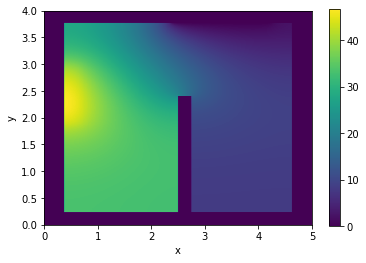

Steady-State


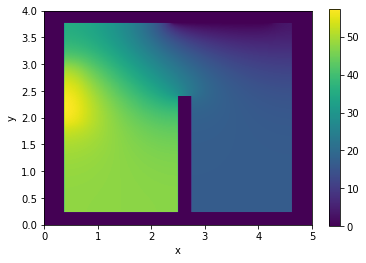

Jacobi


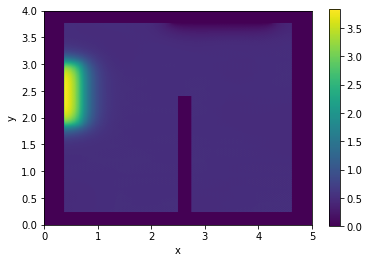

Damped Jacobi


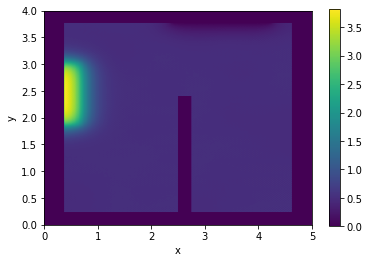

In [3]:
main(200, 200)

Room geometry


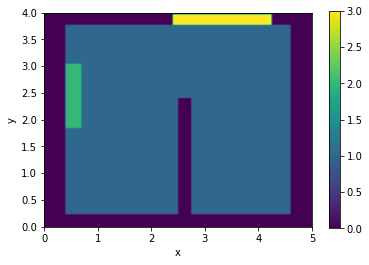

Runge-Kutta 2nd order


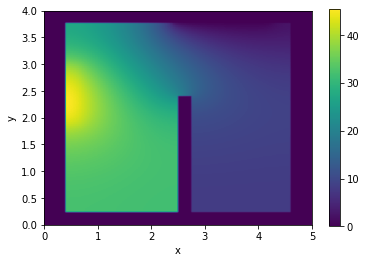

Implicit Midpoint


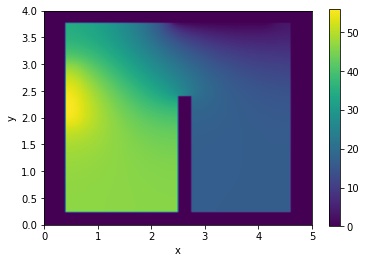

Steady-State


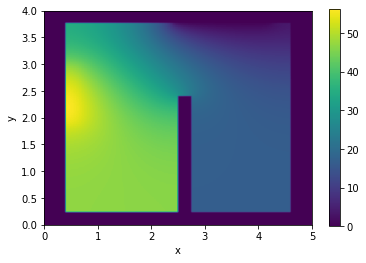

Jacobi


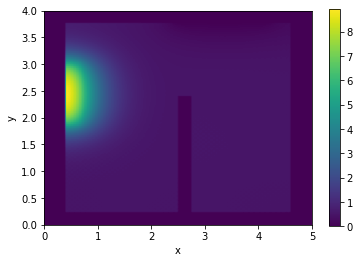

Damped Jacobi


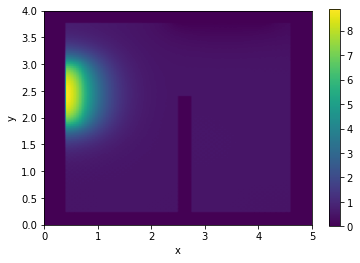

In [4]:
main(100, 100)

Room geometry


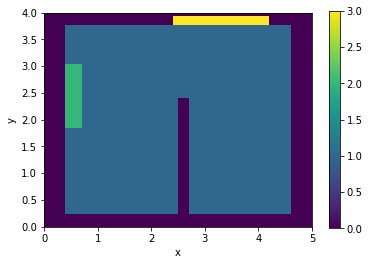

Runge-Kutta 2nd order


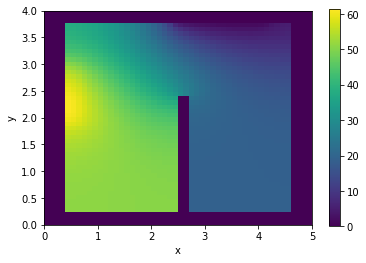

Implicit Midpoint


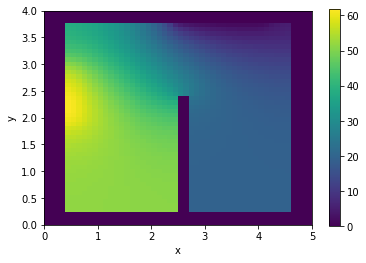

Steady-State


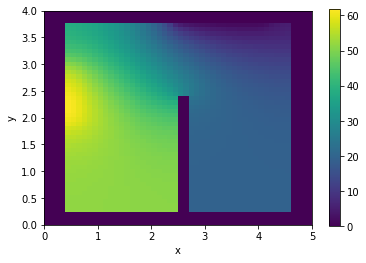

Jacobi


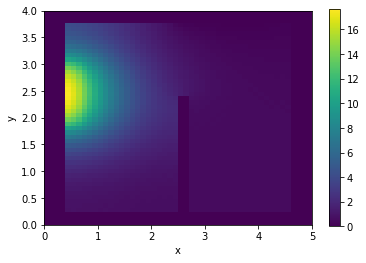

Damped Jacobi


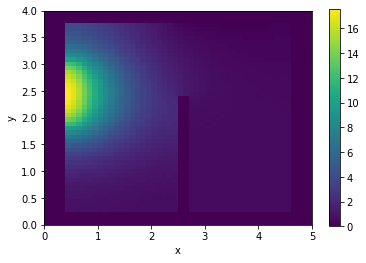

In [5]:
main(50,50)

Room geometry


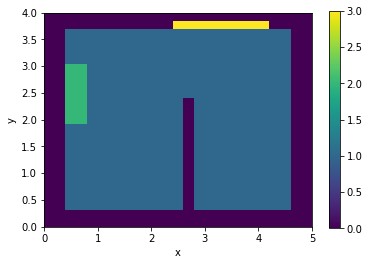

Runge-Kutta 2nd order


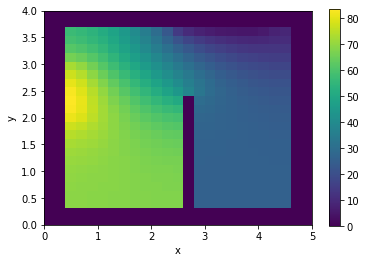

Implicit Midpoint


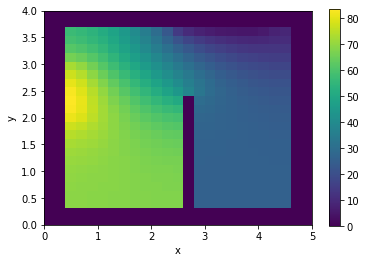

Steady-State


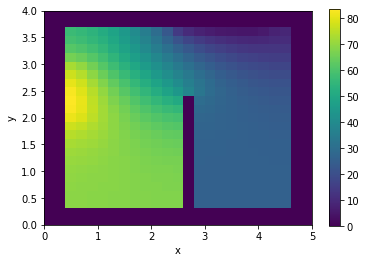

Jacobi


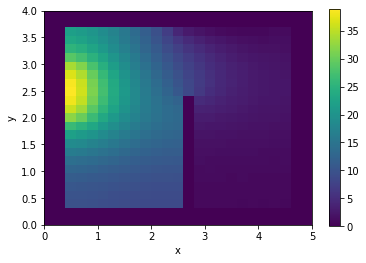

Damped Jacobi


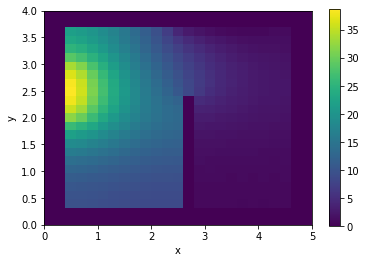

In [6]:
main(25, 25)

## Laplacian Matrix

In [7]:
def laplacian(h):
    row = []
    col = []
    data = []
    sizex = 5
    sizey = 4
    x1d = np.linspace(0, sizex, 200)
    y1d = np.linspace(0, sizey, 200)
    hx = x1d[1]-x1d[0]
    hy = y1d[1]-y1d[0]
    for idof in range(ndofs):
        dg = dofnr_to_geom_ind[idof]
        x,y = dg[0], dg[1]
        for dix, diy, h in [
                (1, 0, hx),
                (-1, 0, hx),
                (0, 1, hy),
                (0, -1, hy)]:
            nxx = int(x + dix)
            nyy = int(y + diy)
            if in_domain[nxx, nyy]:
                ndof = dof_num[nxx, nyy]
                row += [idof, idof]
                col += [ndof, idof]
                data += [1/(h**2), -1/(h**2)]
            elif window[nxx, nyy]:
                row += [idof]
                col += [idof]
                data += [-1/(h**2)]
            else:
                nx2, ny2 = x - dix, y - diy
                ndf1 = dof_num[int(nx2), int(ny2)]
                row += [idof, idof]
                col += [idof, ndf1]
                data += [1/(3*(h**2)), -1/(3*(h**2))]
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    A = sp.coo_matrix((data, (row, col)), shape = (ndofs, ndofs))
    C = A.tocsr()
    return C

## Explicit Time Integrator

In [8]:
def runge_kutta(u):
    sizex = 5
    sizey = 4
    T = 30*np.maximum(sizex, sizey)
    sizenx = 200
    hx = sizex/sizenx
    hy = sizey/sizeny
    ht = 0.5*0.9*(1/(1/(hx**2)+1/(hy**2)))
    nt = T/ht
    t = np.arange(0, T, ht) 
    for i in range(int(nt)):
        k1 = laplacian@u + r
        k2 = ht*(laplacian @ (u + ht*k1/2) + r)
        u = u + k2
    return u

## Implicit Time Integrator

In [9]:
def midpoint(u):
    T = 30*np.maximum(sizex, sizey)
    nt = 3000
    hx = sizex/sizenx
    hy = sizey/sizeny
    ht = 0.5*4*0.9*(1/(1/(hx**2)+1/(hy**2)))
    t = np.arange(0, T, ht)
    A = sp.identity(ndofs)-0.5*ht*laplacian
    solve = sppla.factorized(A)
    for i in range(nt):
        u = solve( u + 0.5*ht*laplacian@u + ht*r)
    return u

## Steady-State 

In [11]:
def steady_state():
    ss = sppla.spsolve(laplacian, -r)
    u_unflat = np.zeros((x.shape))
    u_unflat[in_domain] = ss
    plotfunc(u_unflat)

## Jacobi Method

In [13]:
def jacobi(u, N):
    ur = np.random.rand(ndofs)
    #D = np.diag(laplacian)
    D = sp.diags(laplacian.diagonal(), 0, format = 'coo')
    for i in range(N):
        u = sppla.spsolve(D, -r-(laplacian-D)@u)
    return u

## Damped Jacobi Method

In [14]:
def damped(u, N):
    alpha = 0.005
    u = alpha*u + (1-alpha)*j
    return u

## Explicit Euler

In [15]:
def explicit(u):
    sizex = 5
    sizey = 4
    T = 30*np.maximum(sizex, sizey)
    sizenx = 200
    hx = sizex/sizenx
    hy = sizey/sizeny
    ht = 0.5*0.9*(1/(1/(hx**2)+1/(hy**2)))
    nt = T/ht
    t = np.arange(0, T, ht) 
    for i in range(3000):
        k2 = ht*(laplacian @ u + r)
        u = u + k2
    return u